# **Task 1**


# **Step 1: Install PySpark**

In [12]:
!pip install -q pyspark



# **Step 2: Import Libraries and Create Spark Session**

---



In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("HousingDataAnalysis").getOrCreate()


# **Step 3: Load Dataset**

```

```



In [14]:
df = spark.read.csv("housing.csv", header=True, inferSchema=True)
df.cache()


DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

# **Step 4: Data Exploration**

In [15]:
df.printSchema()
df.show(5)
df.describe().show()


root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

# **Step 5: Check for Missing Values**

In [16]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



# Step 6: Basic GroupBy Analysis

In [17]:
df.groupBy("ocean_proximity").avg("median_house_value").show()
df.groupBy("ocean_proximity").max("median_income").show()


+---------------+-----------------------+
|ocean_proximity|avg(median_house_value)|
+---------------+-----------------------+
|         ISLAND|               380440.0|
|     NEAR OCEAN|     249433.97742663656|
|       NEAR BAY|     259212.31179039303|
|      <1H OCEAN|     240084.28546409807|
|         INLAND|     124805.39200122119|
+---------------+-----------------------+

+---------------+------------------+
|ocean_proximity|max(median_income)|
+---------------+------------------+
|         ISLAND|            3.3906|
|     NEAR OCEAN|           15.0001|
|       NEAR BAY|           15.0001|
|      <1H OCEAN|           15.0001|
|         INLAND|           15.0001|
+---------------+------------------+



# **Step 7: Filter for High-Value, Low-Income Homes**

In [18]:
df.filter((col("median_house_value") > 400000) & (col("median_income") < 2)) \
  .select("longitude", "latitude", "median_income", "median_house_value") \
  .show()


+---------+--------+-------------+------------------+
|longitude|latitude|median_income|median_house_value|
+---------+--------+-------------+------------------+
|  -122.27|    37.8|       1.2434|          500001.0|
|  -122.25|   37.87|       1.1696|          500001.0|
|   -120.1|   38.91|        1.875|          500001.0|
|  -118.34|    34.1|       1.8209|          500001.0|
|  -118.32|    34.1|       1.7306|          450000.0|
|  -118.31|   34.06|       0.8804|          450000.0|
|  -118.31|   34.06|       1.6987|          412500.0|
|   -118.3|   34.06|       1.8214|          475000.0|
|  -118.28|   34.02|       0.4999|          500001.0|
|  -118.15|   34.15|       1.1667|          500001.0|
|  -118.14|   34.15|       1.9923|          500001.0|
|  -118.08|   34.15|       0.4999|          500001.0|
|  -118.49|   34.02|       1.5132|          450000.0|
|  -118.49|   34.01|       1.9722|          500001.0|
|  -118.56|   34.42|       1.9667|          450000.0|
|  -121.89|    36.6|       1

# Step 8: Regression Modeling Using PySpark MLlib

In [19]:
# Remove rows with nulls
df = df.dropna()

# Select features for prediction
feature_cols = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", "median_house_value")

# Train-test split
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
lr = LinearRegression(labelCol="median_house_value", featuresCol="features")
lr_model = lr.fit(train_data)

# Predict
predictions = lr_model.transform(test_data)


# **Step 9: Evaluate the Model**

In [20]:
evaluator_rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Root Mean Squared Error (RMSE): 76768.14224622416
R-squared (R²): 0.5468983835741774


# ***Visualization***

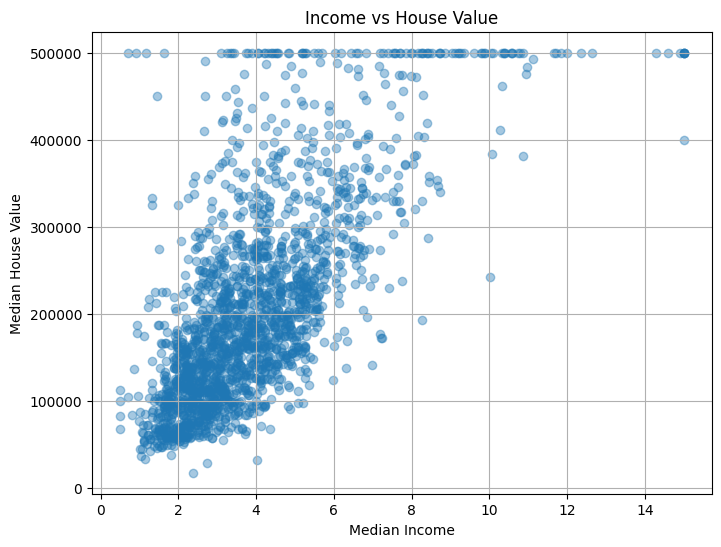

In [21]:
sample_df = df.select("median_income", "median_house_value").sample(False, 0.1).toPandas()

plt.figure(figsize=(8,6))
plt.scatter(sample_df["median_income"], sample_df["median_house_value"], alpha=0.4)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Income vs House Value")
plt.grid(True)
plt.show()


### ✅ Insights Summary:
- "NEAR BAY" areas have high average house values.
- Median income is positively correlated with house value.
- Even in low-income regions, house value can be high due to location.
- The regression model shows a reasonable R², demonstrating predictive capability with PySpark MLlib.
[link text](https://)